In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# to prepare the LULI2000 experiment on Jan. 2025
# about shock-turbulence interaction

# we need to decide the laser focal spot size (and shape) from the random phase plate

# the goal is to have an interaction region that is large
# but also with enough intensity so that Te is not too low

In [ ]:
E_laser   = 100.0  # J
tau_las   = 1e-9  # s
Pow_las   = E_laser / tau_las
print('Power of the main laser beam is P = {:.1e} W'.format(Pow_las))

aa = 0.2  # cm
bb = 0.1  # cm
Size_las  = np.pi * aa * bb # cm^2
# Size_las  = aa*2 * bb*2
I0_laser   = Pow_las / Size_las # W/cm^2
print('Laser intensity is {:.1e} W/cm2'.format(I0_laser))


Power of the main laser beam is P = 1.0e+11 W
Laser intensity is 1.2e+12 W/cm2


In [83]:
# prepare for the calculation of Te

## for low temperature and low density experiment (Te < 300 eV, ne/nc = 1e-2)
## neglecting the electron thermal diffusion
## accounting only for the inverse Bremsstrahlung laser absorption

## (3/2) n_e dT_e / dt = \nu_B I_0 / qe

## n_e:   number density of electron [cm^-3]
## T_e0:  you need an initial value for T_e [eV]
## \nu_B: bremsstrahlung laser absorption coefficient [cm^-1]
## I_0:   laser intensity, usually assume a Gaussian time profile [W/cm^2]
## qe:    elementry charge, [eV = J / 1.6e-19]

# constants in CGS
c    = 3e10              # cm/s, light speed
qe   = 4.8e-10           # elementary charge
hbar = 1.0e-27           # Planck constant
me   = 9.1e-28           # electron mass, g

lmd_las = 1.053*1e-4      # cm, 1 omega laser (1 um)
omg_las = 1.*np.pi*c/lmd_las
print('Laser angular frequency is {:.1e} rad/s'.format(omg_las))

Te = [5.]               # initial temperature
Z0 = 1.                  # material, hydrogen
fwhm = tau_las/2.           # equals to tau_ts above
ne = 1e-1*1.1e21         # cm^-3, number density of the gas

order = 16               # order of gaussian profile
t_end = 5.0e-9           # estimation time
center = t_end / 2.0     # center of gaussian profile

omg_pe  = 5.64e4 * ne**0.5
print('plasma electron angular frequency = {:.1e} rad/s'.format(omg_pe))

Laser angular frequency is 9.0e+14 rad/s
plasma electron angular frequency = 5.9e+14 rad/s


In [84]:
# create the array for time evolution
num = 1000
time = np.linspace(0,t_end,num)
d_time = time[1] - time[0]


# Gaussian profile for the Laser time-evolution
def tgaussian(fwhm,order,center):
    import numpy as np
    sigma = 2.0 * fwhm**order
    return np.exp(-(time-center)**order / sigma)

# Inverse bremsstrahlung absorption coefficient for radiation of angular frequency 𝜔:
# Considered the temperature dependence
def nu_B(temp):
    import numpy as np
    vte  = 4.19e7 * temp**0.5              # cm/s
    V_d1 = hbar/np.sqrt(me*temp*1.6e-12)   # cm, erg s / (g erg)^(1/2), erg -> g cm^2 s^-2, Note here eV -> erg by a factor of 1.6e-12
    V_d2 = Z0*qe**2 / (temp*1.6e-12)       # cm, qe -> m^1/2 l^3/2 / t, 
    V    = np.maximum(omg_las,omg_pe) * np.maximum(V_d1, V_d2)   # cm/s, from NRL (2019) P58 Eq.32
    return 3.1e-7 * Z0 * ne**2 * np.log(vte/V) * temp**(-1.5) * omg_las**-2. * (1.-omg_pe**2/omg_las**2)**(-0.5)   # cm^-1, how to get cm^-1 from this equation????



I_laser = I0_laser*tgaussian(fwhm,order,center)

nuB = np.zeros(num)
# here's the integration, a typo in the formula (2 or e)?
for t in range(num): 
    dt = (nu_B(Te[t])*I_laser[t]/1.5/ne)/1.6e-19 * d_time
    Te.append(Te[t]+dt)
    nuB[t] = nu_B(Te[t])
    # print(r'$\nu_B$ = {:.4e}'.format(nu_B(Te[t])))
    # print('at Te = {:.1e} eV'.format(Te[t]))

In [85]:
# plot the results

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ['/Users/yao/Documents/Calibri and Cambria Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Calibri'

plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=10)



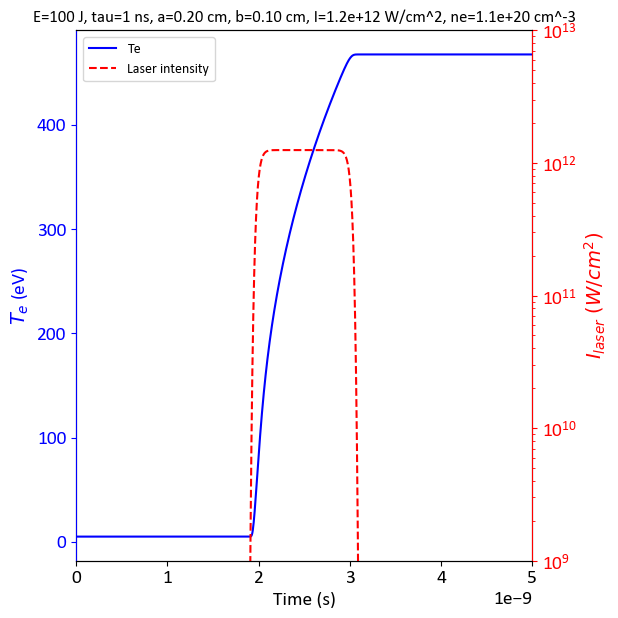

In [86]:


width  = 3.14*2 # single column, 8cm
height = width
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p1, = ax1.plot(time,Te[:-1],'-b',label='Te')
p2, = ax2.semilogy(time,I_laser,'--r',label='Laser intensity')

lines = [p1, p2]
ax1.legend(lines, [l.get_label() for l in lines])
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

# ax1.spines["left"].set_edgecolor(p1.get_color())
ax2.spines["right"].set_edgecolor(p2.get_color())
ax2.spines["left"].set_edgecolor(p1.get_color())

ax1.set_xlabel('Time (s)')
ax1.set_ylabel(r'$T_e$ (eV)')
ax2.set_ylabel(r'$I_{laser} \ (W/cm^2)$')

ax1.set_xlim([0,5e-9])
# ax1.set_ylim([0,100])
ax2.set_ylim([1e9,1e13])

ax1.set_title('E=100 J, tau=1 ns, a={:.2f} cm, b={:.2f} cm, I={:.1e} W/cm^2, ne={:.1e} cm^-3'.format(aa, bb, I0_laser, ne))

ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', which='both', colors=p2.get_color())
# fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.set_size_inches(width, height)
fig.tight_layout()